In [1]:
# https://www.kaggle.com/hajekim/for-beginner/notebook
# https://www.kaggle.com/yongwookkimkor/samplesubmission11135
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns #시각화를 위한 라이브러리
#import calendar 
#from datetime import datetime


# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import os
print(os.listdir("../miniProject/input"))

['sampleSubmission - 복사본.csv', 'sampleSubmission.csv', 'Score_0.33044_submission.csv', 'test.csv', 'train.csv', 'train_bk.csv']


## Bike Sharing Demand 진행방향
1. 훈련, 테스트 데이터셋의 형태 및 컬럼의 속성 데이터 값 파악
2. 데이터 전처리 및 시각화
3. 회귀모델 적용
4. 결론 도출

In [2]:
#훈련데이터와 테스트 데이터 세트를 불러온다
train = pd.read_csv('../miniProject/input/train.csv', parse_dates=["datetime"])
test = pd.read_csv('../miniProject/input/test.csv', parse_dates=['datetime'])
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [3]:
#훈련데이터 셋의 개괄적인 모형 파악
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


해당 데이터 세트에는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재돼 있습니다. 데이터 세트의 주요 칼럼은 다음과 같습니다. 이 중 결정 값은 맨 마지막 칼럼인 count로 '대여 횟수'를 의미합니다.

- datetime: hourly date + timestamp
- season: 1=봄, 2=여름, 3=가을, 4=겨울
- holiday: 1=주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌 날
- workingday: 1=주말 및 휴일이 아닌 주중, 0=주말 및 휴일
- weather:
    - 1=맑음, 약간 구름 낀 흐림
    - 2=안개, 안개 + 흐림
    - 3=가벼운 눈, 가벼운 비 + 천둥
    - 4=심한 눈/비, 천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대습도
- windspeed: 풍속
- casual: 사전에 등록되지 않은 사용자가 대여한 횟수
- registered: 사전에 등록된 사용자가 대여한 횟수
- count: 대여 횟수

In [4]:
#훈련 데이train.head()터셋의 각 컬럼별 데이터타입 및 값의 갯수 파악
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [5]:
#테스트 데이터 셋의 개괄적인 형태 출력
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
# train의 null 인 데이터가 있는지 확인
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [4]:
# train "datetime"로 year, month, day, hour, minute, second column을 추출한다.
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
# V2.0에서 수정
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 17)

In [5]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
# V2.0에서 수정
test["dayofweek"] = test["datetime"].dt.dayofweek
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

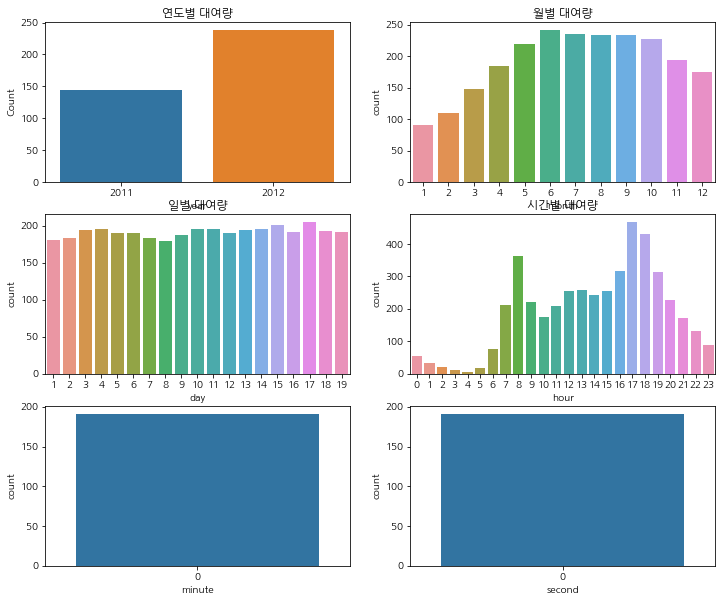

In [10]:
### 각각의 속성과 예측의 결과값으로 쓰이는 count값과의 관계 파악

#년도와 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(3,2,1)
ax1 = sns.barplot(x='year',y='count',data=train.groupby('year')['count'].mean().reset_index())

#month와 count
ax2 = fig.add_subplot(3,2,2)
ax2 = sns.barplot(x='month',y='count',data=train.groupby('month')['count'].mean().reset_index())

#day와 count
ax3 = fig.add_subplot(3,2,3)
ax3 = sns.barplot(x='day',y='count',data=train.groupby('day')['count'].mean().reset_index())

#hour와 count
ax4 = fig.add_subplot(3,2,4)
ax4 = sns.barplot(x='hour',y='count',data=train.groupby('hour')['count'].mean().reset_index())

#minute와 count
ax5 = fig.add_subplot(3,2,5)
ax5 = sns.barplot(x='minute',y='count',data=train.groupby('minute')['count'].mean().reset_index())

#minute와 count
ax6 = fig.add_subplot(3,2,6)
ax6 = sns.barplot(x='second',y='count',data=train.groupby('second')['count'].mean().reset_index())

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

- 연도별 대여량은 2011년 보다 2012년이 더 많다.
- 월별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.
- 일별대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용하면 안 된다.
- 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
- 분, 초도 다 0이기 때문에 의미가 없다.

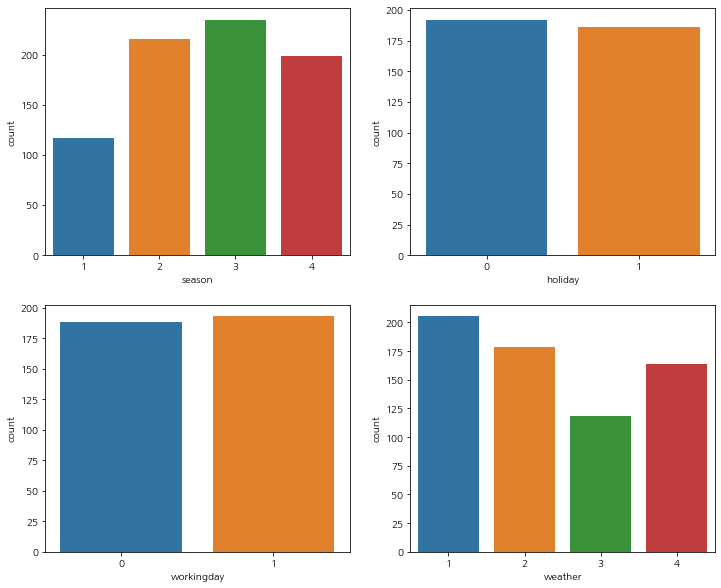

In [11]:
#위의 시각화와 같이 하나의 컬럼과 결과 값을 비교해보자

#계절과 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=train.groupby('season')['count'].mean().reset_index())

#휴일 여부와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='holiday',y='count',data=train.groupby('holiday')['count'].mean().reset_index())

#작업일 여부와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=train.groupby('workingday')['count'].mean().reset_index())

#날씨와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='weather',y='count',data=train.groupby('weather')['count'].mean().reset_index())

C:\Users\difud\AppData\Local\Temp/ipykernel_6572/2319425769.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[['temp', 'windspeed']].hist(bins=20, ax=ax)


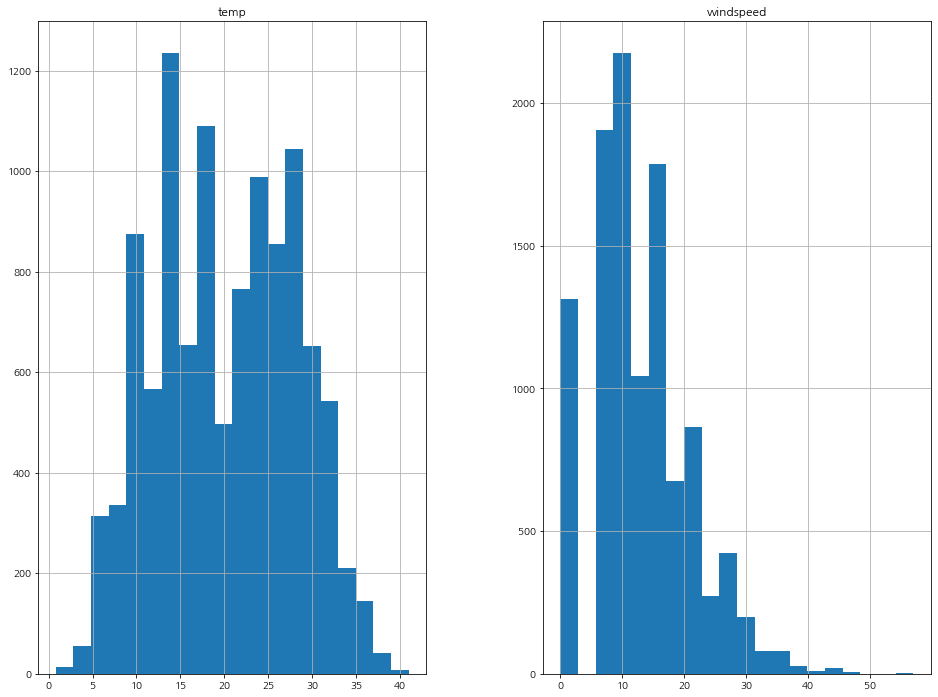

In [12]:
fig, ax = plt.subplots(figsize=(16,12))
 
# temp, windspeed 의 히스토그램
train[['temp', 'windspeed']].hist(bins=20, ax=ax)

plt.show()

<AxesSubplot:xlabel='YM', ylabel='count'>

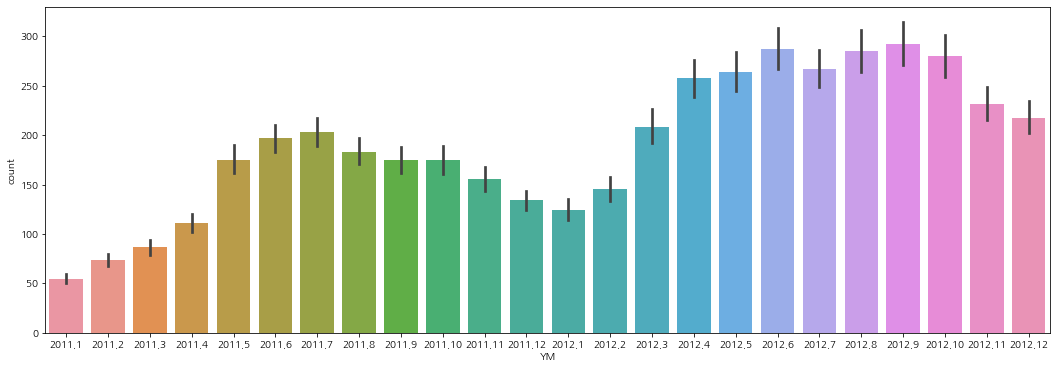

In [13]:
def ym(mydt):
    return"{0}.{1}".format(mydt.year,mydt.month)
train['YM'] = train['datetime'].apply(ym)

fig = plt.figure(figsize=(18,6))
sns.barplot(data=train, x='YM', y="count") #2011년대비 12년에 대여수 증가

In [14]:
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 20)

In [15]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='hour', ylabel='count'>

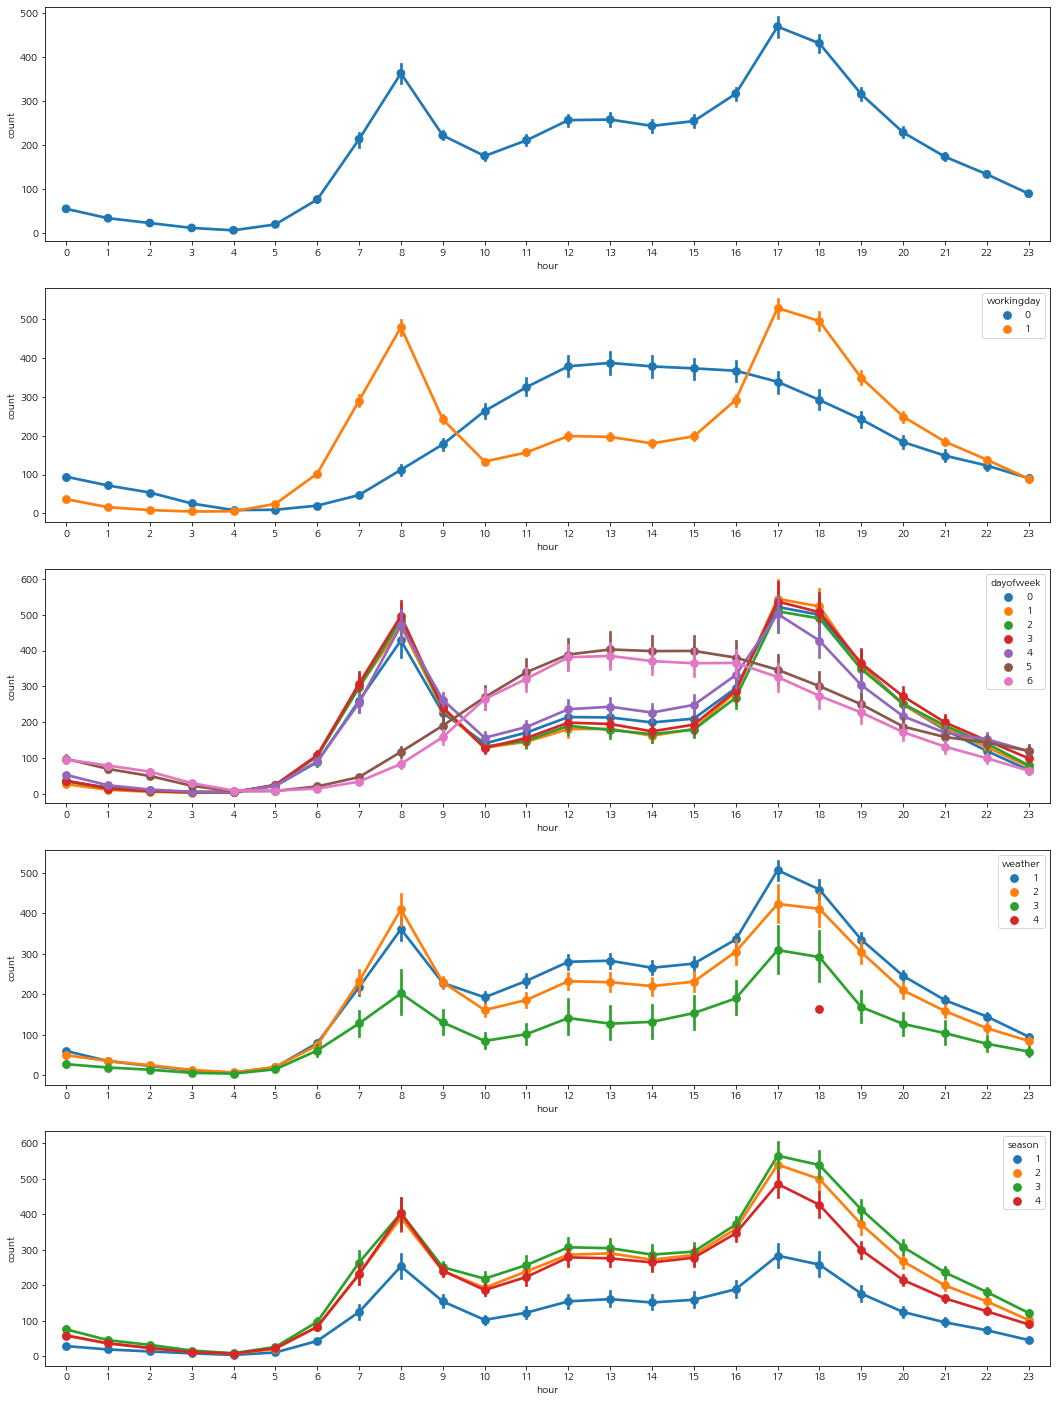

In [16]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

#시간 따른 count
sns.pointplot(data=train, x="hour", y="count", ax=ax1)
#시간과 휴일 여부에 따른 count
sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)
#시간과 요일(휴일) 여부에 따른 count
sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)
#시간과 날씨에 따른 count
sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)
#시간과 계절에 따른 count
sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

In [18]:
#시간별 정렬을 위해 string type의 datetime을 datetime으로 변환
train.datetime = pd.to_datetime(train.datetime,errors='coerce')

In [19]:
#합쳐진 데이터를 datetime순으로 정렬
train = train.sort_values(by=['datetime'])

In [20]:
# minute, second 불필요한 항목삭제
train = train.drop('minute', axis = 'columns')
train = train.drop('second', axis = 'columns')

C:\Users\difud\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\difud\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


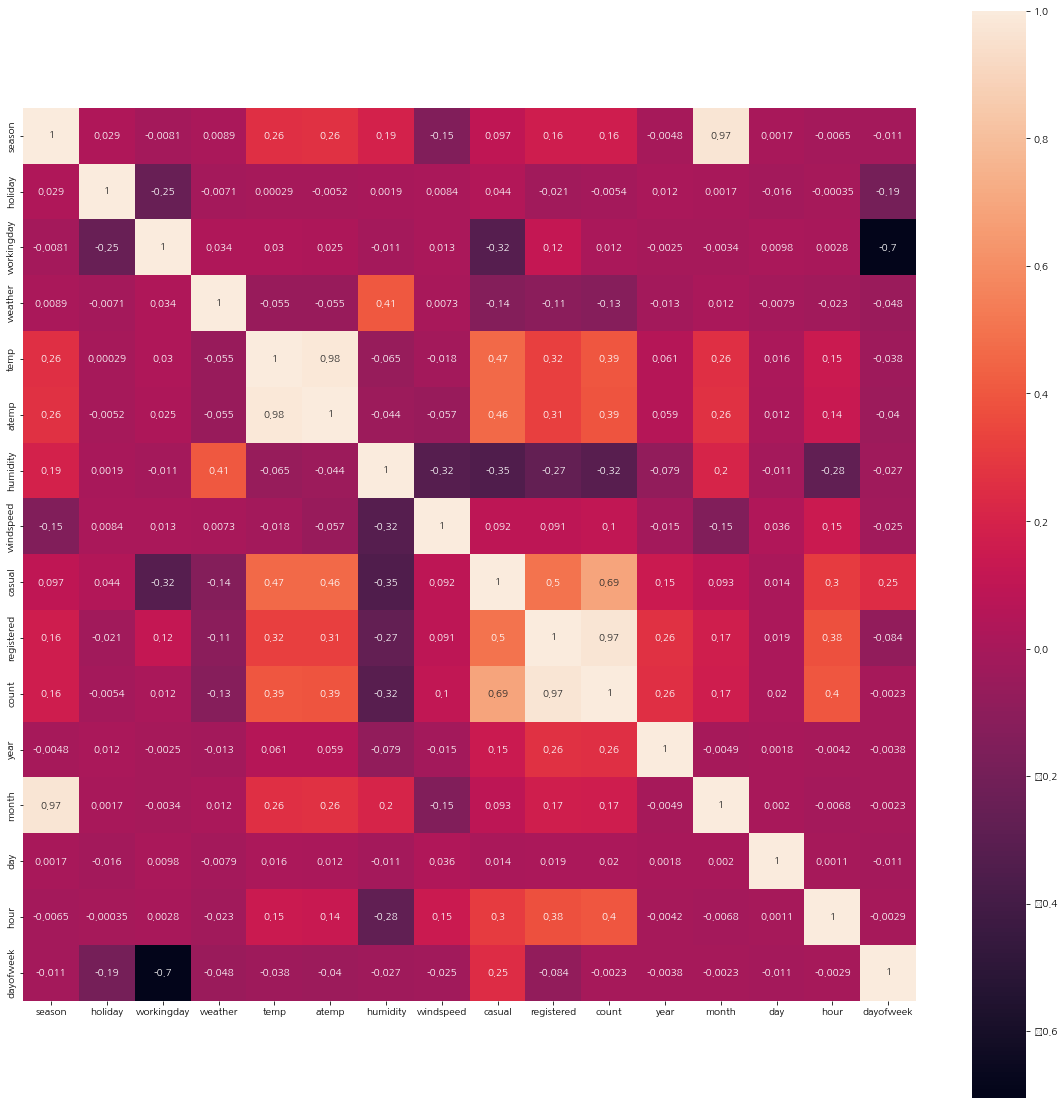

In [21]:
#windspeed를 수정한 후 다시 상관계수를 분석
#우리의 기대와는 달리 windspeed와 count의 상관관계는 0.1에서 0.11로 간소한 차이만 보임.
fig = plt.figure(figsize=[20,20])
ax = sns.heatmap(train.corr(),annot=True,square=True)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
 16  YM          10886 non-

## Feature Selection

In [7]:
inttocat = ["season", "holiday", "workingday", "weather",'year','month','day','hour'] #as type으로 category 형변환 
for i in inttocat:
    train[i] = train[i].astype("category")
    test[i] = test[i].astype("category")

drop_columns = ['datetime','casual','registered']
train.drop(drop_columns, axis=1,inplace=True)
    
inttocat
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   count       10886 non-null  int64   
 9   year        10886 non-null  category
 10  month       10886 non-null  category
 11  day         10886 non-null  category
 12  hour        10886 non-null  category
 13  dayofweek   10886 non-null  int64   
dtypes: category(8), float64(3), int64(3)
memory usage: 598.0 KB


In [8]:
features = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]
features
# V2.0에서 수정
# "windspeed", "workingday" feature를 추가 0.48286 --> 0.41977로 줄어듬

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [9]:
X_train = train[features]

print(X_train.shape)
X_train.head(10)

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,0.0000,2011,0,5,0,0
1,1,1,9.02,13.635,80,0.0000,2011,1,5,0,0
2,1,1,9.02,13.635,80,0.0000,2011,2,5,0,0
3,1,1,9.84,14.395,75,0.0000,2011,3,5,0,0
4,1,1,9.84,14.395,75,0.0000,2011,4,5,0,0
5,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
6,1,1,9.02,13.635,80,0.0000,2011,6,5,0,0
7,1,1,8.20,12.880,86,0.0000,2011,7,5,0,0
8,1,1,9.84,14.395,75,0.0000,2011,8,5,0,0
9,1,1,13.12,17.425,76,0.0000,2011,9,5,0,0


In [10]:
X_test = test[features]

print(X_test.shape)
X_test.head(10)

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1
5,1,1,9.84,11.365,60,15.0013,2011,5,3,0,1
6,1,1,9.02,10.605,60,15.0013,2011,6,3,0,1
7,1,1,9.02,10.605,55,15.0013,2011,7,3,0,1
8,1,1,9.02,10.605,55,19.0012,2011,8,3,0,1
9,1,2,9.84,11.365,52,15.0013,2011,9,3,0,1


In [11]:
label = 'count'
y_train = train[label]
y_train.head(10)

0    16
1    40
2    32
3    13
4     1
5     1
6     2
7     3
8     8
9    14
Name: count, dtype: int64

In [12]:
#아웃라이어 제거 함수, count열값 - count열값 평균 < 3 * (count.std)
trainWithOutliers = train[np.abs(train["count"]-train["count"].mean())<= (3*train["count"].std())]
print(train.shape) #전
print(trainWithOutliers.shape) #후
print(X_train.shape)
print(X_test.shape)
### 추가로 로그 테스트 확인

(10886, 14)
(10739, 14)
(10886, 11)
(6493, 11)


In [13]:
def rmsle(predicted_value, actual_value): #오류 값의 로그에 대한 RMSE
    predicted_value=np.array(predicted_value) # 예측값과 실제 값을 numpy 배열 형태로 변환
    actual_value=np.array(actual_value) # 예측값과 실제 값을 numpy 배열 형태로 변환
    
    log_predict=np.log(predicted_value+1) # 예측값과 실제 값에 1을 더하고 로그 변환
    log_actual=np.log(actual_value+1) # 예측값과 실제 값에 1을 더하고 로그 변환
    
    diff=log_predict-log_actual # 로그 변환한 예측값에서 로그 변환한 실제 값을 빼고 제곱
    diff=np.square(diff) # 로그 변환한 예측값에서 로그 변환한 실제 값을 빼고 제곱
    
    mean_diff=diff.mean() # 위에서 계산한 값의 평균
    
    score=np.sqrt(mean_diff) # 위에서 계산한 값에 루트
    return score

In [24]:
from sklearn.metrics import make_scorer #1 Random Forest 방식 사용
rmsle_scorer=make_scorer(rmsle)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from pandas import DataFrame

kfold=KFold(n_splits=10, shuffle=True, random_state=42) #K Fold 교차검증

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

model =RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=60)

%time score=cross_val_score(model, X_train, y_train,cv=kfold, scoring=rmsle_scorer )
print('Rmsle Random Forest Score:',score.mean())

Wall time: 12.1 s
Rmsle Random Forest Score: 0.33024223987347057


In [16]:
# V2.0에서 수정
y_train_log = np.log1p(y_train)

model.fit(X_train, y_train_log)

RandomForestRegressor(n_jobs=-1, random_state=60)

In [17]:
prediction=model.predict(X_test)
prediction

array([2.42247724, 1.76478574, 1.37405217, ..., 4.61146061, 4.59417851,
       3.85068526])

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)

score = rmsle(np.exp(y_train_log), np.exp(preds))
print("RMSLE Gradient Boost:", score)

RMSLE Gradient Boost: 0.20417262895601526


In [20]:
df1 = pd.read_csv('../miniProject/input/sampleSubmission.csv')
# V2.0에서 수정
df1['count'] = np.exp(prediction)
df1.to_csv('Score_{0:.5f}_test_submission.csv'.format(score), index=False)
df1.head(10)

# 0.39931 까지
# from sklearn.experimental import enable_hist_gradient_boosting from sklearn.ensemble import HistGradientBoostingRegressor 확인해보기

,datetime,count
0,2011-01-20 00:00:00,11.273753
1,2011-01-20 01:00:00,5.840321
2,2011-01-20 02:00:00,3.951330
3,2011-01-20 03:00:00,4.269092
4,2011-01-20 04:00:00,3.738412
5,2011-01-20 05:00:00,7.363551
6,2011-01-20 06:00:00,38.571456
7,2011-01-20 07:00:00,106.793951
8,2011-01-20 08:00:00,240.907657
9,2011-01-20 09:00:00,137.886283
